# word2vec

## 추론 기반 기법과 신경망

### 신경망에서의 단어 처리

In [1]:
import numpy as np
c= np.array([[1,0,0,0,0,0,0]]) # 입력
W = np.random.randn(7,3) # 가중치
h = np.matmul(c,W) # 중간 노드
print(h) # 어짜피 W의 첫번째 행만 추출된 것(c의 0번 인덱스만 1이라)

[[-0.42141401 -0.2739443   1.17874205]]


In [2]:
# 위와 같은 방법
import sys
sys.path.append('..')
from common.layers import MatMul
c= np.array([[1,0,0,0,0,0,0]]) # 입력
W = np.random.randn(7,3) # 가중치
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[-0.48497083 -0.44951849  0.55477786]]


In [3]:
# class MatMul:
#     def __init__(self, W):
#         self.params = [W]
#         self.grads = [np.zeros_like(W)]
#         self.x = None

#     def forward(self, x):
#         W, = self.params
#         out = np.dot(x, W)
#         self.x = x
#         return out

#     def backward(self, dout):
#         W, = self.params
#         dx = np.dot(dout, W.T)
#         dW = np.dot(self.x.T, dout)
#         self.grads[0][...] = dW
#         return dx

## 단순한 word2vec

### CBOW 모델의 추론 처리

In [4]:
# 샘플 맥락 데이터
c0 = np.array([[1,0,0,0,0,0,0]])
c1 = np.array([[0,0,1,0,0,0,0]])

# 가중치 초기화
W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5*(h0+h1)
s = out_layer.forward(h)

print(s)

[[ 0.15185582  0.95926142 -0.03853401  0.94476295 -0.6739493  -0.73088847
  -0.18969716]]


## 학습데이터 준비

### 맥락과 타깃 준비

In [5]:
from common.util import preprocess
text = 'you say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

[0 1 2 3 4 1 5 6]


In [6]:
print(id_to_word)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [7]:
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size] # 양끝 두개 단어 제거
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size) : # 1~7
            cs = []
            for t in range(-window_size,window_size+1):
                if t == 0:
                    continue
                cs.append(corpus[idx+t])
            contexts.append(cs)
    return np.array(contexts), np.array(target)

In [8]:
contexts, target = create_contexts_target(corpus, window_size=1)
contexts, target # 아직 단어 ID 표시

(array([[0, 2],
        [1, 3],
        [2, 4],
        [3, 1],
        [4, 5],
        [1, 6]]),
 array([1, 2, 3, 4, 1, 5]))

### 원핫 표현으로 변환

In [9]:
# def convert_one_hot(corpus, vocab_size):
#     '''원핫 표현으로 변환

#     :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
#     :param vocab_size: 어휘 수
#     :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
#     '''
#     N = corpus.shape[0] # corpus 개수 

#     if corpus.ndim == 1:
#         one_hot = np.zeros((N, vocab_size), dtype=np.int32) # 8행(corpus 단어 나열) 7열(vocab 단어 나열) 
#         for idx, word_id in enumerate(corpus):
#             one_hot[idx, word_id] = 1

#     elif corpus.ndim == 2:
#         C = corpus.shape[1]
#         one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
#         for idx_0, word_ids in enumerate(corpus):
#             for idx_1, word_id in enumerate(word_ids):
#                 one_hot[idx_0, idx_1, word_id] = 1

#     return one_hot

# # corpus를 행에 나열, 열에 vocab 나열하여 해당하는 인덱스에 1 추가

In [10]:
from common.util import convert_one_hot
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [9]:
target # say, goodbye, and, i, say, hello

array([1, 2, 3, 4, 1, 5])

In [10]:
target.shape 

(6,)

In [11]:
contexts

array([[0, 2],
       [1, 3],
       [2, 4],
       [3, 1],
       [4, 5],
       [1, 6]])

In [12]:
contexts.shape
# 0번째 차원의 원소 수 : 미니 배치의 수, 1번째 차원 : 맥락의 윈도우 크기, 2번째 차원 : 원핫벡터

(6, 2)

## CBOW 모델 구현

In [13]:
from common.layers import SoftmaxWithLoss
class SimpleCBOW :
    def __init__(self, vocab_size, hidden_size) :
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f') # 단어의 one_hot이 넘어오기에 vocab 크기가 input size
        W_out = 0.01 * np.random.randn(H, V).astype('f') # 최종 output도 one_hot으로
        
        # 계층 생성 - 입력층의 맥락을 처리하는 MatMul 계층은 맥락에서 사용하는 단어의 수(윈도우 크기)만큼 만들어야 한다.
        self.in_layers0 = MatMul(W_in)
        self.in_layers1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모은다
        layers = [self.in_layers0, self.in_layers1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers :
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산표현을 저장한다
        self.word_vecs = W_in
        
    def forward(self, contexts, target) :
        h0 = self.in_layers0.forward(contexts[:,0]) # 앞에 위치한 단어 인덱싱
        h1 = self.in_layers1.forward(contexts[:,1]) # 뒤에 위치한 단어 인덱싱
        h = (h0+h1)*0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
        
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layers0.backward(da)
        self.in_layers1.backward(da)
        return None

In [14]:
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import convert_one_hot

### 학습코드구현

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

| 에폭 402 |  반복 1 / 2 | 시간 0[s] | 손실 1.06
| 에폭 403 |  반복 1 / 2 | 시간 0[s] | 손실 0.71
| 에폭 404 |  반복 1 / 2 | 시간 0[s] | 손실 0.91
| 에폭 405 |  반복 1 / 2 | 시간 0[s] | 손실 0.81
| 에폭 406 |  반복 1 / 2 | 시간 0[s] | 손실 0.93
| 에폭 407 |  반복 1 / 2 | 시간 0[s] | 손실 0.83
| 에폭 408 |  반복 1 / 2 | 시간 0[s] | 손실 0.99
| 에폭 409 |  반복 1 / 2 | 시간 0[s] | 손실 0.87
| 에폭 410 |  반복 1 / 2 | 시간 0[s] | 손실 0.74
| 에폭 411 |  반복 1 / 2 | 시간 0[s] | 손실 0.91
| 에폭 412 |  반복 1 / 2 | 시간 0[s] | 손실 0.99
| 에폭 413 |  반복 1 / 2 | 시간 0[s] | 손실 0.80
| 에폭 414 |  반복 1 / 2 | 시간 0[s] | 손실 0.78
| 에폭 415 |  반복 1 / 2 | 시간 0[s] | 손실 0.82
| 에폭 416 |  반복 1 / 2 | 시간 0[s] | 손실 0.86
| 에폭 417 |  반복 1 / 2 | 시간 0[s] | 손실 0.78
| 에폭 418 |  반복 1 / 2 | 시간 0[s] | 손실 1.07
| 에폭 419 |  반복 1 / 2 | 시간 0[s] | 손실 0.86
| 에폭 420 |  반복 1 / 2 | 시간 0[s] | 손실 0.79
| 에폭 421 |  반복 1 / 2 | 시간 0[s] | 손실 0.73
| 에폭 422 |  반복 1 / 2 | 시간 0[s] | 손실 0.96
| 에폭 423 |  반복 1 / 2 | 시간 0[s] | 손실 0.87
| 에폭 424 |  반복 1 / 2 | 시간 0[s] | 손실 0.85
| 에폭 425 |  반복 1 / 2 | 시간 0[s] | 손실 0.79
| 에폭 426 |  반복 1

| 에폭 847 |  반복 1 / 2 | 시간 0[s] | 손실 0.73
| 에폭 848 |  반복 1 / 2 | 시간 0[s] | 손실 0.58
| 에폭 849 |  반복 1 / 2 | 시간 0[s] | 손실 0.56
| 에폭 850 |  반복 1 / 2 | 시간 0[s] | 손실 0.45
| 에폭 851 |  반복 1 / 2 | 시간 0[s] | 손실 0.56
| 에폭 852 |  반복 1 / 2 | 시간 0[s] | 손실 0.60
| 에폭 853 |  반복 1 / 2 | 시간 0[s] | 손실 0.70
| 에폭 854 |  반복 1 / 2 | 시간 0[s] | 손실 0.45
| 에폭 855 |  반복 1 / 2 | 시간 0[s] | 손실 0.58
| 에폭 856 |  반복 1 / 2 | 시간 0[s] | 손실 0.56
| 에폭 857 |  반복 1 / 2 | 시간 0[s] | 손실 0.72
| 에폭 858 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 859 |  반복 1 / 2 | 시간 0[s] | 손실 0.41
| 에폭 860 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 861 |  반복 1 / 2 | 시간 0[s] | 손실 0.57
| 에폭 862 |  반복 1 / 2 | 시간 0[s] | 손실 0.72
| 에폭 863 |  반복 1 / 2 | 시간 0[s] | 손실 0.57
| 에폭 864 |  반복 1 / 2 | 시간 0[s] | 손실 0.57
| 에폭 865 |  반복 1 / 2 | 시간 0[s] | 손실 0.28
| 에폭 866 |  반복 1 / 2 | 시간 0[s] | 손실 0.84
| 에폭 867 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 868 |  반복 1 / 2 | 시간 0[s] | 손실 0.40
| 에폭 869 |  반복 1 / 2 | 시간 0[s] | 손실 0.44
| 에폭 870 |  반복 1 / 2 | 시간 0[s] | 손실 0.99
| 에폭 871 |  반복 1

C:\Users\choi yeseul\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\choi yeseul\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\choi yeseul\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\choi yeseul\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\choi yeseul\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\choi yeseul\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeW

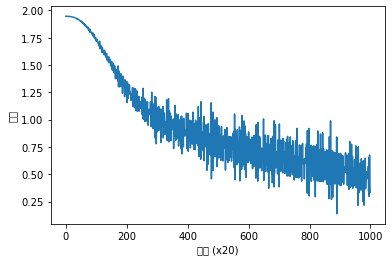

In [15]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'you say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [18]:
word_vec = model.word_vecs
word_vec

array([[ 1.0492952 , -0.9568056 , -0.98690504, -1.6712848 , -0.99108785],
       [ 0.85725665,  1.2114464 ,  1.2099236 , -0.9948473 ,  1.190958  ],
       [ 0.9261205 , -0.9865468 , -0.9535624 ,  0.71350104, -1.0102464 ],
       [ 2.037427  ,  0.82657623,  0.9256296 , -0.80120903,  0.9750227 ],
       [ 0.91111773, -0.98700976, -0.9503307 ,  0.7015406 , -0.9994906 ],
       [ 1.0478266 , -0.9529329 , -0.9924881 , -1.6615956 , -1.0098722 ],
       [-0.85080194,  1.3044351 ,  1.1853867 , -0.99973977,  1.1089725 ]],
      dtype=float32)

In [21]:
id_to_word.items()

dict_items([(0, 'you'), (1, 'say'), (2, 'goodbye'), (3, 'and'), (4, 'i'), (5, 'hello'), (6, '.')])

In [20]:
for word_id, word in id_to_word.items():
    print(word, word_vec[word_id])

you [ 1.0492952  -0.9568056  -0.98690504 -1.6712848  -0.99108785]
say [ 0.85725665  1.2114464   1.2099236  -0.9948473   1.190958  ]
goodbye [ 0.9261205  -0.9865468  -0.9535624   0.71350104 -1.0102464 ]
and [ 2.037427    0.82657623  0.9256296  -0.80120903  0.9750227 ]
i [ 0.91111773 -0.98700976 -0.9503307   0.7015406  -0.9994906 ]
hello [ 1.0478266 -0.9529329 -0.9924881 -1.6615956 -1.0098722]
. [-0.85080194  1.3044351   1.1853867  -0.99973977  1.1089725 ]
